In [1]:
import pathlib
import re
import itertools

import numpy as np


import geojson
import geopandas
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = pathlib.Path('~/src/sealevel/data/deltares/nl-below-sl').expanduser()

In [3]:
features = []
paths = data_dir.glob('*.geojson')
for path in paths:
    with path.open() as f:
        data = geojson.load(f)
        for feature in data['features']:
            feature['properties']['filename'] = path.name
        features.extend(data.features)

In [4]:
features = geojson.FeatureCollection(features=features)

In [5]:
gdf = geopandas.GeoDataFrame.from_features(features)

In [6]:
filename_pattern = re.compile(r'05m-noclip-(?P<i>\d+)-(?P<j>\d+)ee_export.geojson')
gdf['file_info'] = gdf.filename.apply(lambda x: filename_pattern.search(x).groupdict())
gdf['i'] = gdf['file_info'].apply(lambda x: int(x['i']))
gdf['j'] = gdf['file_info'].apply(lambda x: int(x['j']))

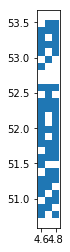

In [7]:
ax = gdf[np.logical_and(gdf['i'] > 12, gdf['i']<  16)].plot()


In [8]:
gdf[['i', 'j']].sort_values(['i', 'j'])
set(range(40)) - set(gdf['i'])

{3, 16, 20, 24, 28, 32, 36}

In [9]:
gdf['n_gte0'] = gdf['nGte0'].apply(lambda x: x['elevation'])
gdf['n_lt0'] = gdf['nLt0'].apply(lambda x: x['elevation'])
gdf['total'] = gdf['n_lt0'] + gdf['n_gte0']
gdf['total_count'] = gdf['count'].apply(lambda x: x['elevation'])
gdf['masked_frac'] = gdf['maskedFrac'].apply(lambda x: x['elevation'])

In [10]:
gdf['bins'] = gdf['hist'].apply(lambda x: x['elevation']).apply(lambda x: [x_i[0] for x_i in x] if x else [])
gdf['counts'] = gdf['hist'].apply(lambda x: x['elevation']).apply(lambda x: [x_i[1] for x_i in x] if x else [])

In [11]:
gte0 = gdf['n_gte0'].sum() 
lt0 = gdf['n_lt0'].sum()
lt0 / (gte0 + lt0)

0.2511982382373728

In [12]:
bins = list(itertools.chain.from_iterable(gdf['bins'].values))
counts = list(itertools.chain.from_iterable(gdf['counts'].values))
np.min(bins), np.max(bins), np.min(counts), np.max(counts)

(-15.41, 83307.52, 0.0, 252703487.65881482)

In [13]:
gdf['max_bins'] = gdf['bins'].apply(lambda x: np.max(x) if x else 0)

In [17]:
row = gdf.sort_values('max_bins', ascending=False).iloc[:1]

In [20]:
row

,count,filename,geometry,hist,maskedFrac,nGte0,nLt0,file_info,i,j,n_gte0,n_lt0,total,total_count,masked_frac,bins,counts,max_bins
114,{'elevation': 263777984},05m-noclip-13-14ee_export.geojson,"POLYGON ((4.546542493526175 52.1287083934524, ...","{'elevation': [[-15.36, 20158.0], [-10.2399999...",{'elevation': 0.8665202564578398},{'elevation': 7777304.568627451},{'elevation': 256001651.36078432},"{'i': '13', 'j': '14'}",13,14,7.777305e+06,2.560017e+08,2.637790e+08,263777984,0.86652,"[-15.36, -10.239999999999998, -5.1199999999999...","[20158.0, 3278005.7019607895, 252703487.658814...",83307.52
